In [1]:
#| echo: true
import numpy as np
import pandas as pd
import os
import re
from sklearn.decomposition import PCA

import tensorflow as tf
from threading import Thread
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import pickle
import random
from tqdm import tqdm
import plotly.express as px
from plotly.offline import init_notebook_mode
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
init_notebook_mode(connected=True)


In [43]:
#from google.colab import drive
#drive.mount('/content/drive')


NO CORRER LA SIGUIENTE CELDA

In [44]:
#import zipfile
#import os

# Ruta del archivo ZIP en tu Google Drive
#zip_path = '/content/drive/Shareddrives/Redes 2024_1/Trabajo 3/archive.zip'

# Ruta donde deseas extraer los archivos
#extract_to = '/content/drive/Shareddrives/Redes 2024_1/Trabajo 3/extracted_files'

# Crear el directorio si no existe
#os.makedirs(extract_to, exist_ok=True)

# Descomprimir el archivo
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_to)

#print(f'Archivos extraídos en: {extract_to}')


In [2]:

styles_df = pd.read_csv("./Datos/styles.csv", on_bad_lines='skip')
styles_df['filename'] = styles_df['id'].astype(str) + '.jpg'

#Nota: primero cambiar images por pruebas y correr, luego volver a poner images y ahi si lee todas las direcciones, es raro al verdad

#Esto parece que no hace falta en qmd
image_files = os.listdir("./Datos/extracted_files/images")



def check_image_path(filename):
    path = os.path.join("./Datos/extracted_files/images", filename)
    return path if os.path.exists(path) else None

styles_df['filename'] = styles_df['filename'].apply(check_image_path)

# Filtrar filas donde la imagen no existe
styles_df = styles_df[styles_df['filename'].notnull()]
styles_df['file_found'] = styles_df['id'].apply(lambda x: f"{x}.jpg" in image_files)
styles_df = styles_df[styles_df['file_found']].reset_index(drop=True)
#styles_df.shape[0]

#styles_df.isnull().sum()
# Eliminamos las filas que contienen valores faltantes
styles_df_clean = styles_df.dropna()

# Revisamos nuevamente la cantidad de valores nulos en cada columna para asegurarnos de que se han eliminado
#print(styles_df_clean.isnull().sum())


styles_df_clean.drop(columns=['productDisplayName','file_found'],inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_14256\2765336041.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [3]:
fig = px.bar(styles_df_clean.groupby('masterCategory').count().reset_index(), x='masterCategory',y='id',title='Count per Product Category')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

In [4]:
styles_df_clean = styles_df_clean.sample(frac=1).reset_index(drop=True)
n = len(styles_df_clean)
train = styles_df_clean.iloc[:int(n*0.8),:]
val = styles_df_clean.iloc[int(n*0.8):,:].reset_index(drop=True)

In [10]:
#val_path = '../Modelos/val_data.csv'
#val.to_csv(val_path, index=False)
# Definir la ruta para guardar el archivo en formato .pkl
val_path_pkl = './Modelos/val_data.pkl'
#val_path_pkl="Documents/GitHub/fashionIA/Trabajo 3/Modelos"




# Guardar el dataframe 'val' en formato pickle
val.to_pickle(val_path_pkl)

In [49]:
# Cargar el dataframe 'val' desde el archivo .pkl
#val_loaded = pd.read_csv(val_path)


In [11]:
# Crear una muestra de 5000 filas para el conjunto de entrenamiento
train_sampled = train.sample(n=3000, random_state=42).reset_index(drop=True)

# Crear una muestra de 1000 filas para el conjunto de validación
val_sampled = val.sample(n = 600, random_state=42).reset_index(drop=True)


In [14]:
datagen = ImageDataGenerator(rescale=1/255.)

train_generator = datagen.flow_from_dataframe(dataframe=train_sampled,
                                             target_size=(256,256),
                                             x_col='filename',
                                             class_mode=None,
                                             batch_size=32,
                                             shuffle=False,
                                             classes=['images'])

val_generator = datagen.flow_from_dataframe(dataframe=val_sampled,
                                             target_size=(256,256),
                                             x_col='filename',
                                             class_mode=None,
                                             batch_size=32,
                                             shuffle=False,
                                             classes=['images'])

Found 3000 validated image filenames.


c:\Users\DELL\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:854: UserWarning:

`classes` will be ignored given the class_mode="None"



Found 600 validated image filenames.


In [13]:
train_generator

NameError: name 'train_generator' is not defined

**Una muestra de imagen entrenamiento**

(32, 256, 256, 3)


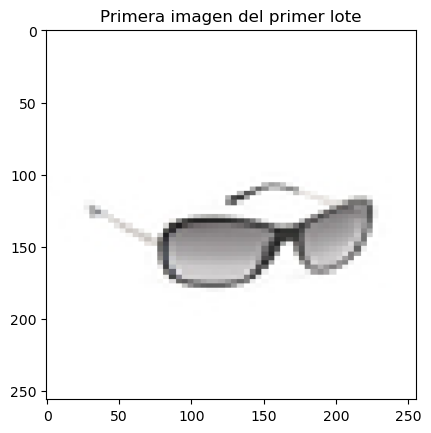

In [15]:
# Obtener el primer lote de imágenes
images_batch = next(train_generator)
# Imprimir la forma del lote de imágenes
print(images_batch.shape)  # Debe ser (32, 256, 256, 3) si batch_size=32 y las imágenes son RGB
# Mostrar la primera imagen del lote
import matplotlib.pyplot as plt
plt.imshow(images_batch[0])
plt.title('Primera imagen del primer lote')
plt.show()

**muestra de una imagen de entrenamiento**

(32, 256, 256, 3)


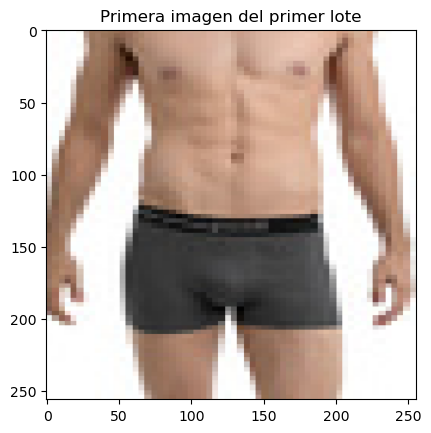

In [54]:
# Obtener el primer lote de imágenes
images_batch = next(val_generator)
# Imprimir la forma del lote de imágenes
print(images_batch.shape)  # Debe ser (32, 256, 256, 3) si batch_size=32 y las imágenes son RGB
# Mostrar la primera imagen del lote
import matplotlib.pyplot as plt
plt.imshow(images_batch[0])
plt.title('Primera imagen del primer lote')
plt.show()


In [9]:
base_model = VGG16(include_top=False,input_shape=(256,256,3))

model = Sequential()
for layer in base_model.layers:
    model.add(layer)
model.add(GlobalAveragePooling2D())
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:


val_features = model.predict(val_generator,verbose=1)

train_features = model.predict(train_generator,verbose=1)

#import pickle

# Especificar la ruta para guardar los archivos
train_features_path = './Modelos/train_features.pkl'
val_features_path = './Modelos/val_features.pkl'

# Guardar train_features en un archivo .pkl
with open(train_features_path, 'wb') as f:
    pickle.dump(train_features, f)

# Guardar val_features en un archivo .pkl
with open(val_features_path, 'wb') as f:
    pickle.dump(val_features, f)

c:\Users\DELL\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



19/19 ━━━━━━━━━━━━━━━━━━━━ 199s 10s/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 963s 10s/step


Guardar los objetos

# llamar lo objetos cargados

In [11]:
import pickle

# Especificar la ruta para cargar los archivos
train_features_path = './Modelos/train_features.pkl'
val_features_path = './Modelos/val_features.pkl'

# Cargar train_features desde el archivo .pkl
with open(train_features_path, 'rb') as f:
    train_features = pickle.load(f)

# Cargar val_features desde el archivo .pkl
with open(val_features_path, 'rb') as f:
    val_features = pickle.load(f)

In [12]:
from sklearn.decomposition import PCA
# Inicializar PCA para reducir las características a 2 dimensiones
pca = PCA(2)

# Ajustar PCA a las características de entrenamiento y luego transformar
pca.fit(train_features)
train_pca = pca.transform(train_features)

# Aplicar PCA al conjunto de validación y transformarlo
test_pca = pca.fit_transform(val_features)

# Convertir las características reducidas de entrenamiento a un DataFrame
train_pca = pd.DataFrame(train_pca)

# Seleccionar las primeras 10 columnas del conjunto de entrenamiento original
train = train.iloc[:,0:10]

# Combinar las características originales con las nuevas características reducidas por PCA
train = train.merge(train_pca, how='left', left_index=True, right_index=True)


In [13]:
fig = px.scatter(train, x=0, y=1, color="masterCategory", title='Main Category', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [14]:
fig = px.scatter(train, x=0, y=1, color="gender", title='Gender', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [15]:
fig = px.scatter(train, x=0, y=1, color="subCategory", title='Sub Category', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [17]:

# Entrenar el PCA con los datos de entrenamiento
pca = PCA(n_components=313)  # Puedes ajustar el número de componentes según lo que necesites
pca.fit(train_features)

# Guardar el modelo PCA entrenado en la ruta especificada
pca_model_path = './Modelos/pca_model.pkl'
with open(pca_model_path, 'wb') as f:
    pickle.dump(pca, f)

In [18]:
#pca = PCA()
#pca.fit(train_features)

train_pca = pca.transform(train_features)
variance_explained = np.cumsum(pca.explained_variance_ratio_)
pcs = range(1,len(variance_explained)+1)
px.line(x = pcs, y = variance_explained, title = 'Principal Components Cumulative Explained Variance', height=600,  labels={
                     "x": "Principal Components",
                     "y": "Explained Variance"})

In [19]:
px.line(x = pcs, y = variance_explained, title = 'Principal Components Cumulative Explained Variance', height=600,  labels={
                     "x": "Principal Components",
                     "y": "Explained Variance"})

In [23]:
val_pca = pca.fit_transform(val_features)[:,:313]
# Especificar la ruta para guardar el modelo PCA
val_pca = pd.DataFrame(val_pca)
val = val_sampled.iloc[:,0:10]
val = val.merge(val_pca, how='left', left_index=True, right_index=True)
X = val.iloc[:,-313:]
y = val['id']

In [24]:
val_pca

,0,1,2,3,4,5,6,7,8,9,...,303,304,305,306,307,308,309,310,311,312
0,0.086292,0.544658,-0.014557,0.518313,0.701143,0.331531,-0.303520,-0.281101,-0.006231,0.415671,...,-0.007758,0.000209,0.006987,-0.019727,0.008523,0.017584,0.016807,-0.003976,0.003212,-0.000932
1,-1.024791,0.454989,0.032500,-0.068961,-0.316235,-0.055210,-0.168969,0.220536,0.072375,0.014843,...,0.012898,-0.010131,0.011814,0.005153,0.000979,-0.005848,0.001567,0.006480,-0.016067,-0.005075
2,0.918977,-0.608005,-0.441852,0.555291,-0.115923,-0.219489,0.377925,0.233780,0.046582,-0.538196,...,-0.003319,-0.010513,0.026008,0.005506,0.009303,0.011304,0.005074,0.003125,-0.020833,-0.005147
3,1.313796,-0.214564,-0.925858,-0.062045,0.426332,-0.052673,-0.302307,-0.013759,-0.119698,0.486056,...,-0.006170,0.002789,-0.019995,0.006969,0.020553,0.009691,0.007171,-0.002979,0.017730,0.001089
4,-1.305843,0.196407,-0.366013,0.056396,0.139363,0.219406,-0.129836,0.121229,0.243952,-0.129152,...,-0.001672,-0.002852,0.010994,-0.003465,0.011172,0.030358,0.001761,0.014567,-0.002689,0.001106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1.174163,-0.149677,0.138403,-0.315707,0.127858,0.100443,0.008369,0.480992,-0.296118,-0.624990,...,0.012075,0.019549,0.003515,-0.003020,-0.008533,0.015516,0.010349,0.002472,-0.005267,0.003381
596,-0.046006,0.113908,0.634318,-0.145579,0.875190,-0.104766,0.052687,-0.284136,0.395789,0.023212,...,0.002709,-0.012799,-0.026429,0.009307,-0.004623,0.002013,-0.011213,0.006186,0.000916,-0.009727
597,-1.332752,-0.949539,-0.990723,0.080660,0.228758,0.011013,0.236021,-0.170437,0.033203,0.147976,...,-0.000126,0.010497,0.004340,-0.011358,-0.002808,0.005528,0.000648,-0.005902,0.003787,-0.002339
598,1.280177,0.509754,0.055520,0.039098,-0.561482,-0.154232,0.317446,-0.151126,-0.082347,-0.235278,...,-0.010295,-0.000642,0.000711,-0.000856,0.009884,0.005898,-0.004582,-0.004594,0.005597,-0.018172


In [78]:


# Cargar el modelo PCA desde el archivo .pkl
# with open(pca_model_path, 'rb') as f:
#     loaded_pca = pickle.load(f)

In [25]:
val_pca

,0,1,2,3,4,5,6,7,8,9,...,303,304,305,306,307,308,309,310,311,312
0,0.086292,0.544658,-0.014557,0.518313,0.701143,0.331531,-0.303520,-0.281101,-0.006231,0.415671,...,-0.007758,0.000209,0.006987,-0.019727,0.008523,0.017584,0.016807,-0.003976,0.003212,-0.000932
1,-1.024791,0.454989,0.032500,-0.068961,-0.316235,-0.055210,-0.168969,0.220536,0.072375,0.014843,...,0.012898,-0.010131,0.011814,0.005153,0.000979,-0.005848,0.001567,0.006480,-0.016067,-0.005075
2,0.918977,-0.608005,-0.441852,0.555291,-0.115923,-0.219489,0.377925,0.233780,0.046582,-0.538196,...,-0.003319,-0.010513,0.026008,0.005506,0.009303,0.011304,0.005074,0.003125,-0.020833,-0.005147
3,1.313796,-0.214564,-0.925858,-0.062045,0.426332,-0.052673,-0.302307,-0.013759,-0.119698,0.486056,...,-0.006170,0.002789,-0.019995,0.006969,0.020553,0.009691,0.007171,-0.002979,0.017730,0.001089
4,-1.305843,0.196407,-0.366013,0.056396,0.139363,0.219406,-0.129836,0.121229,0.243952,-0.129152,...,-0.001672,-0.002852,0.010994,-0.003465,0.011172,0.030358,0.001761,0.014567,-0.002689,0.001106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1.174163,-0.149677,0.138403,-0.315707,0.127858,0.100443,0.008369,0.480992,-0.296118,-0.624990,...,0.012075,0.019549,0.003515,-0.003020,-0.008533,0.015516,0.010349,0.002472,-0.005267,0.003381
596,-0.046006,0.113908,0.634318,-0.145579,0.875190,-0.104766,0.052687,-0.284136,0.395789,0.023212,...,0.002709,-0.012799,-0.026429,0.009307,-0.004623,0.002013,-0.011213,0.006186,0.000916,-0.009727
597,-1.332752,-0.949539,-0.990723,0.080660,0.228758,0.011013,0.236021,-0.170437,0.033203,0.147976,...,-0.000126,0.010497,0.004340,-0.011358,-0.002808,0.005528,0.000648,-0.005902,0.003787,-0.002339
598,1.280177,0.509754,0.055520,0.039098,-0.561482,-0.154232,0.317446,-0.151126,-0.082347,-0.235278,...,-0.010295,-0.000642,0.000711,-0.000856,0.009884,0.005898,-0.004582,-0.004594,0.005597,-0.018172


In [26]:
val_sampled

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,filename
0,53931,Women,Accessories,Bags,Handbags,Grey,Summer,2012.0,Casual,../Datos/extracted_files/images\53931.jpg
1,41705,Women,Footwear,Shoes,Heels,Blue,Winter,2012.0,Casual,../Datos/extracted_files/images\41705.jpg
2,46894,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,../Datos/extracted_files/images\46894.jpg
3,18369,Men,Apparel,Innerwear,Innerwear Vests,White,Summer,2016.0,Casual,../Datos/extracted_files/images\18369.jpg
4,5047,Men,Footwear,Shoes,Sports Shoes,Black,Summer,2011.0,Sports,../Datos/extracted_files/images\5047.jpg
...,...,...,...,...,...,...,...,...,...,...
595,41695,Men,Apparel,Bottomwear,Shorts,Navy Blue,Summer,2012.0,Casual,../Datos/extracted_files/images\41695.jpg
596,10734,Women,Accessories,Bags,Handbags,Green,Winter,2015.0,Casual,../Datos/extracted_files/images\10734.jpg
597,30488,Women,Apparel,Innerwear,Bra,White,Summer,2014.0,Casual,../Datos/extracted_files/images\30488.jpg
598,44926,Men,Apparel,Topwear,Shirts,Blue,Summer,2012.0,Casual,../Datos/extracted_files/images\44926.jpg


In [27]:
from sklearn.neighbors import KNeighborsClassifier
import pickle

# Suponiendo que X e y ya están definidos
# Especificar la ruta para guardar el modelo
knn_model_path = '../Modelos/knn_model.pkl'

# Entrenar el modelo KNN
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X, y)

# Guardar el modelo KNN en un archivo .pkl
with open(knn_model_path, 'wb') as f:
    pickle.dump(neigh, f)

In [69]:
# for _ in range(5):
#     i = random.randint(1,len(val))
#     img1 = read_img(val_sampled.loc[i,'filename'])
#     dist, index = neigh.kneighbors(X=X.iloc[i,:].values.reshape(1,-1))
#     plt.figure(figsize = (4 , 4))
#     plt.imshow(img1)
#     plt.title("Input Image")

#     plt.figure(figsize = (20 , 20))
#     for i in range(1,6):
#         plt.subplot(1 , 5, i)
#         plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
#         image = read_img(val_sampled.loc[index[0][i],'filename'])
#         plt.imshow(image)
#         plt.title(f'Similar Product #{i}')

## implementación del modelo

In [28]:

# Función para leer y procesar una imagen
def read_img(image_path):
    image = load_img(image_path, target_size=(256, 256, 3))
    image = img_to_array(image)
    image = image / 255.0
    return image

# Función para recomendar productos similares
def recommend_similar_products(input_image_path, model, pca, neigh, val_sampled, num_recommendations=5):
    # Leer y procesar la imagen de entrada proporcionada por el usuario
    img1 = read_img(input_image_path)

    # Extraer características visuales de la imagen de entrada utilizando el modelo preentrenado
    img_features = model.predict(np.expand_dims(img1, axis=0))

    # Aplicar PCA a las características de la imagen de entrada
    img_features_pca = pca.transform(img_features)

    # Encontrar las imágenes más similares en el dataset utilizando KNN
    dist, index = neigh.kneighbors(img_features_pca[0][:313].reshape(1, -1))

    # Visualizar la imagen de entrada
    plt.figure(figsize=(4, 4))
    plt.imshow(img1)
    plt.title("Input Image")
    plt.show()



    # Visualizar las imágenes más similares del dataset
    plt.figure(figsize=(20, 20))
    for i in range(1, num_recommendations + 1):
        plt.subplot(1, num_recommendations, i)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        similar_image_path = val_sampled.loc[index[0][i-1], 'filename']
        similar_image = read_img(similar_image_path)
        plt.imshow(similar_image)
        plt.title(f'Similar Product #{i}')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


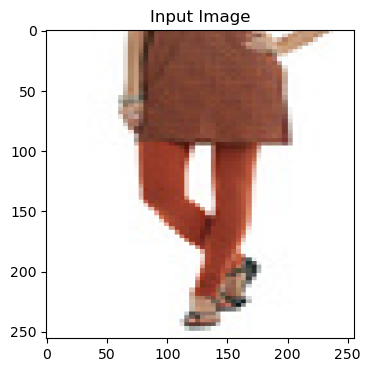

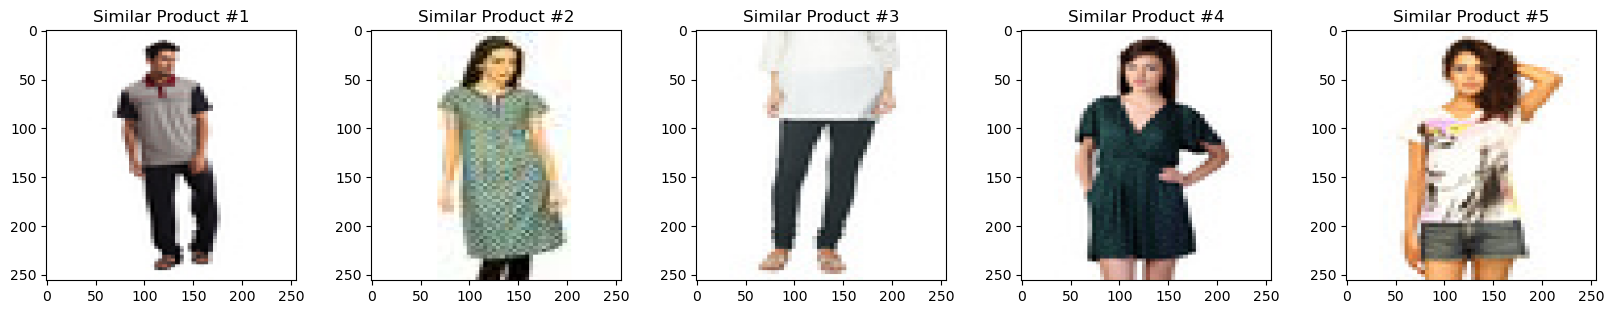

In [29]:


# Ejemplo de uso de la función
input_image_path = './Datos/extracted_files/pruebas/54055.jpg'

# Llamar a la función de recomendación
recommend_similar_products(input_image_path, model, pca, neigh, val_sampled, num_recommendations=5)

In [72]:
 # Leer y procesar la imagen de entrada proporcionada por el usuario
 

img1 = read_img(input_image_path)

    # Extraer características visuales de la imagen de entrada utilizando el modelo preentrenado
img_features = model.predict(np.expand_dims(img1, axis=0))

    # Aplicar PCA a las características de la imagen de entrada
img_features_pca = pca.transform(img_features)

    # Encontrar las imágenes más similares en el dataset utilizando KNN
dist, index = neigh.kneighbors(img_features_pca)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


In [73]:
index

array([[119,  35,  64,  25,  28, 110]], dtype=int64)

In [74]:
dist

array([[1.14166296, 1.17964542, 1.32284343, 1.39744365, 1.41744328,
        1.43063378]])

In [75]:
similar_image_path = val_sampled.loc[index[0][1-1], 'filename']

In [76]:
similar_image_path

'../Datos/extracted_files/images\\36219.jpg'

In [77]:
index

array([[119,  35,  64,  25,  28, 110]], dtype=int64)